Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = ""
COLLABORATORS = ""

---

# CSE 30 Fall 2021 - Homework 6


### Instructions

Please disregard the YOUR NAME and COLLABORATORS above.  They are put there atomatically by the grading tool.
You can find instructions on how to work on a homework on Canvas.  Here is a short summary: 

### Submitting your work

To submit your work: 

* First, click on "Runtime > Restart and run all", and check that you get no errors.  This enables you to catch any error you might have introduced, and not noticed, due to your running cells out of order. 
* Second, download the notebook in .ipynb format (File > Download .ipynb) and upload the .ipynb file to [this form](https://docs.google.com/forms/d/e/1FAIpQLSe0vOde5Z0Ou1AMd3qrXrdYJ_x1an4hVjtRogPBRMXZ3LsJew/viewform?usp=sf_link). 

You can submit multiple times; the last submission before the deadline is the one that counts.

### Homework format

For each question in this notebook, there is: 

* A text description of the problem. 
* One or more places where you have to insert your solution.  You need to complete every place marked: 

    `# YOUR CODE HERE`
    
    and you should not modify any other place. 
* One or more test cells.  Each cell is worth some number of points, marked at the top.  You should not modify these tests cells.  The tests pass if no error is printed out: when there is a statement that says, for instance: 

    `assert x == 2`
    
    then the test passes if `x` has value 2, and fails otherwise.  You can insert a `print(x)` (for this case!) somewhere if you want to debug your work; it is up to you.  
    
### Notes:

* Your code will be tested both according to the tests you can see (the `assert` statements you can see), _and_ additional tests.  This prevents you from hard-coding the answer to the particular questions posed.  Your code should solve the _general_ intended case, not hard-code the particular answer for the values used in the tests. 

* **Please do not delete or add cells!** The test is autograded, and if you modify the test by adding or deleting cells, even if you re-add cells you delete, you may not receive credit. 

* **Please do not import modules that are not part of the [standard library](https://docs.python.org/3/library/index.html).** You do not need any, and they will likely not available in the grading environment, leading your code to fail. 

* **If you are inactive too long, your notebook might get disconnected from the back-end.** Your work is never lost, but you have to re-run all the cells before you continue. 

* You can write out print statements in your code, to help you test/debug it. But remember: the code is graded on the basis of what it outputs or returns, not on the basis of what it prints.

* **TAs and tutors have access to this notebook,** so if you let them know you need their help, they can look at your work and give you advice. 

### Grading

Each cell where there are tests is worth a certain number of points.  You get the points allocated to a cell only if you pass _all_ the tests in the cell. 

The tests in a cell include both the tests you can see, and other, similar, tests that are used for grading only.  Therefore, you cannot hard-code the solutions: you really have to solve the essence of the problem, to receive the points in a cell. 

### Code of Conduct

* Work on the test yourself, alone. 
* You can search documentation on the web, on sites such as the Python documentation sites, Stackoverflow, and similar, and you can use the results. 
* You cannot share your work with others or solicit their help.


# The Buses Go Round and Round

[... and round and round!](https://www.youtube.com/watch?v=e_04ZrNroTo)

Your goal, in this homework assignment, is to write a bus simulator.  Similarly to the UCSC campus, there is one or more buses that travel along a circular route, with `num_stops` stops.  People have a destination in mind, and go to a stop to join the queue for the bus in very British fashion. Once the bus arrives, they climb on (provided there is enough space), ride on the bus till their stop, and then step down. 

We will be able to vary the number of buses, bus capacity, time it takes for the bus to reach a stop and for a person to climb on/off, and see how the time people take to reach their destination changes as a consequence.  You will write the key parts of the simulator, while much of the tedious work is done for you. 

Let us begin! 

## The Event-Based Simulator

Here is again our code to implement the event-based simulator. 

In [2]:
from collections import deque # Used to implement queues.
import random # Random choice, etc.
import heapq # Used in discrete event simulator
import numpy as np # Used for gamma probability distribution, and percentiles.
import matplotlib.pyplot as plt
import itertools
from tabulate import tabulate # To display the bus status.


In [3]:
def fmt(x):
    """Formats a number x which can be None, for convenience."""
    return None if x is None else "{:.2f}".format(x)

class Event(object):

    def __init__(self, method, delay=0, args=None, kwargs=None):
        """An event consists in calling a specified method after a delay,
        with a given list of args and kwargs."""
        self.method = method
        self.delay = delay
        self.args = args or []
        self.kwargs = kwargs or {}
        self.time = None # Not known until this is added to the queue.

    def __call__(self, time):
        """This causes the event to happen, returning a list of new events
        as a result. Informs the object of the time of occurrence."""
        return self.method(*self.args, time=time, **self.kwargs)

    def __lt__(self, other):
        return self.time < other.time

    def __repr__(self):
        return "@{}: {} {} {} {} dt={:.2f}".format(
            fmt(self.time),
            self.method.__self__.__class__.__name__,
            self.method.__name__,
            self.args, self.kwargs, self.delay
        )


In [4]:
class EventSimulator(object):

    def __init__(self, trace=False):
        self.events = []
        self.time = 0 # This is the global time.
        self.trace = trace

    def add_event(self, event):
        """Adds an event to the queue."""
        event.time = self.time + event.delay
        heapq.heappush(self.events, event)

    def step(self):
        """Performs a step of the simulation."""
        if len(self.events) > 0:
            event = heapq.heappop(self.events)
            self.time = event.time
            new_events = event(self.time) or []
            for e in new_events:
                self.add_event(e)
            if self.trace:
                print("Processing:", event)
                print("New events:", new_events)
                print("Future events:", self.events)

    def steps(self, number=None):
        """Performs at most number steps (or infinity, if number is None)
        in the simulation."""
        num_done = 0
        while len(self.events) > 0:
            self.step()
            num_done += 1
            if num_done == number:
                break


## The Classes / Actors in the Simulation

### Person

Here is the class for a person.  We give it to you as it contains really nothing very interesting, and having named properties for the transit times of a person helps us in writing the visualization code later on.  

Notice how every person has a source and a destination.  You have to make sure that people get off the bus at the right stop!

In [5]:
class Person(object):

    def __init__(self, start_time, source, destination, have_arrived,
                 person_id=None):
        """
        @param start_time: time at which a person enters the system.
        @param source: stop at which the person wants to climb on.
        @param destination: destination stop.
        @param have_arrived: list of people who have arrived, so we can
            plot their bus time.
        """
        self.start_time = start_time
        self.bus_time = None # Time at which climbed on bus
        self.end_time = None
        self.source = source
        self.destination = destination
        self.have_arrived = have_arrived
        # for id purpose
        self.id = person_id

    # Event method
    def arrived(self, time=None):
        """The person has arrived to their destination."""
        self.end_time = time
        self.have_arrived.append(self)
        return [] # No events generated as a consequence.

    def start_bus(self, time=None):
        """The person starts getting on the bus."""
        self.bus_time = time

    @property
    def elapsed_time(self):
        return None if self.end_time is None else self.end_time - self.start_time

    @property
    def travel_time(self):
        return None if self.end_time is None else self.end_time - self.bus_time

    @property
    def wait_time(self):
        return None if self.end_time is None else self.bus_time - self.start_time

    def __repr__(self):
        return f"Person #: {self.id}, source: {self.source}, dest: {self.destination}"


### Source

Here is the `Source` class, in charge of generating people and adding them to the bus stops.  There isn't much interesting going on here, and we provide the implementation for you so the statistical process of people generation is clear. 

In [6]:
class Source(object):
    """Creates people, and adds them to the queues."""

    def __init__(self, rate=1., queue_ring=None, number=None, have_arrived=None):
        """
        @param rate is the rate at which people are generated.
        @param number is the total number of people to generate; None = unlimited.
        @param queue_ring is the queue ring (a list of queues) where people are added.
        @param have_arrived is the list where people who have arrived are added.
        """
        self.rate = rate
        self.queue_ring = queue_ring
        self.num_stops = len(queue_ring)
        self.number = number
        self.have_arrived = have_arrived
        self.person_id = 0 # For debugging.

    # Event method
    def start(self, time=None):
        if self.number == 0:
            return [] # Nothing more to be done.
        # Creates the person
        self.person_id += 1
        source, destination = random.sample(range(self.num_stops), 2)
        person = Person(time, source, destination, self.have_arrived,
                        person_id = self.person_id)
        queue = self.queue_ring[source]
        enter_event = Event(queue.enter, args=[person])
        # Schedules the next person creation.
        self.number = None if self.number is None else self.number - 1
        dt = np.random.gamma(1, 1/self.rate)
        start_event = Event(self.start, delay=dt)
        return [enter_event, start_event]


### Question 1: Implement a Queue

Here is the class `Queue`.  Every bus stop has a queue.  The `Source` (code above) calls the method `enter` of the queue to add people to it.  When the bus stops at a given stop, the people in the queue need to climb on, if there is space for them in the bus.  

We leave it up to you to implement the queue.  Feel free to add any methods and properties you need. 

In [7]:
### Class Queue

class Queue(object):

    def __init__(self):
        """We create a queue."""
        self.people = deque()

    # Event method
    def enter(self, person, time=None):
        self.people.append(person)
        return []

    ### You can put here any other methods that might help you.
    def exit(self):
        """Picks a person out of the queue, or None if the
        queue is empty."""
        if len(self.people) > 0:
            return self.people.popleft()
        else: 
            return None

    def __len__(self):
        return len(self.people)

    def getList(self):
        return self.people

    #When the bus stops at a given stop, the people in the queue need to climb on, if there is space for them in the bus.?


### Question 2: Implement a Bus

The bus is the centerpiece of our simulation.  The bus behaves as follows. 

When the bus arrives to a stop: 

* first people for whom the stop is the destination get off, one by one, 
* then people waiting get on, one by one, up to when the queue is empty or the max capacity of the bus is reached,
* and finally, it drives to the next station. 

A person climbing on or off the bus takes time given by `np.random.gamma(2, geton_time / 2)`.  You are advised to model as events the climbing up/down of every person. 

The bus takes time given by `np.random.gamma(10, nextstop_time / 10)` to drive to the next stop. 

The initializer of the bus takes as parameters the ring of queues (one queue for each stop), so that it has access to the people climbing on/off the bus.   It also takes as parameters the bus max capacity, and the times for people to get on and off. 

We leave it up to you to write all the interesting bits of the bus implementation.

In [8]:
#@ title Class Bus

class Bus(object):

    def __init__(self, queue_ring, max_capacity, geton_time, nextstop_time,
                 bus_id=None):
        """The bus is created with the following parameters:
        @param max_capacity: the max capacity of the bus.
        @param queue_ring: the ring (list) of queues representing the stops.
        @param geton_time: the expected time that it takes for a person to climb
            the 2 steps to get on the bus.  The time a person takes to get on is
            given by np.random.gamma(2, geton_time / 2).
            This is the same as the time to get off the bus.
        @param nextstop_time: the average time the bus takes to go from one stop
            to the next.  The actual time is given by
            np.random.gamma(10, nextstop_time/10).
        @param bus_id: An id for the bus, for debugging.
        """
        self.queue_ring = queue_ring
        self.max_capacity = max_capacity
        self.geton_time = geton_time
        self.nextstop_time = nextstop_time
        self.id = bus_id
        ### Put any other thing you need in the initialization below.
        self.busList = []
        self.index = 0
        self.stop_idx = 0
        self.total_delay = 0
        #self.queue = self.queue_ring[self.stop_id]

    @property
    def stop(self):
        """Returns the current (most recent) stop of the bus,
        as an integer."""
        return self.stop_idx

    @property
    def onboard(self):
        """Returns the list of people on the bus."""
        return self.busList

    @property
    def occupancy(self):
        """Returns the number of passengers on the bus."""
        return len(self.busList)

    # Event method.
    def arrive(self, stop_idx, time=None):
        """Arrives at the next stop."""
        queue = self.queue_ring[stop_idx]
        if len(self.busList) > 0:
            dt = np.random.gamma(2, self.geton_time / 2)
            self.total_delay = self.total_delay + dt
            return [Event(self.unLoad, delay = self.total_delay, args = [stop_idx])]
        else:
            dt = np.random.gamma(2, self.geton_time / 2)
            self.total_delay = self.total_delay + dt
            return [Event(self.load, delay = self.total_delay, args = [self.stop_idx])]

    def __repr__(self):
        """This will print a bus, which helps in debugging."""
        return "Bus#: {}, #people: {}, dest: {}".format(
            self.id, self.occupancy, [p.destination for p in self.onboard])
    ### You can have as many other methods as you like, including other
    ### events for the bus.  Up to you.

    def unLoad(self, stop_idx, time=None):
        x = False
        y = None
        for i in range(0, len(self.busList)):
            if self.busList[i].destination == self.stop_idx:
                x = True
                y = self.busList.pop(i)
                break
        if x == True:
            dt = np.random.gamma(2, self.geton_time / 2)
            self.total_delay = self.total_delay + dt
            return [Event(self.unLoad, delay = dt, args = [self.stop_idx]), Event(y.arrived, delay = self.total_delay)]

        else:
            #self.total_delay = self.total_delay + np.random.gamma(2, self.geton_time / 2)
            return [Event(self.load, delay = np.random.gamma(2, self.geton_time / 2), args = [self.stop_idx])]

    def load(self, stop_idx, time=None):
        queue = self.queue_ring[self.stop_idx]

        if len(queue) > 0 and len(self.busList) < self.max_capacity:
            self.busList.append(queue.exit())
            a = self.busList[len(self.busList) - 1]
            dt = np.random.gamma(2, self.geton_time / 2)
            self.total_delay = self.total_delay + dt
            return [Event(self.load, delay = np.random.gamma(2, self.geton_time / 2), args = [self.stop_idx]), Event(a.start_bus, delay = self.total_delay)]
        
        else:
            dt = np.random.gamma(10, self.geton_time / 10)
            self.total_delay = self.total_delay + dt
            return [Event(self.driveDriveDrive, delay = self.total_delay)]

    def driveDriveDrive(self, time = None):
        queue = self.queue_ring[self.stop_idx]
        self.total_delay = 0
        if self.stop_idx == None:
            self.stop_idx = 0
        elif self.stop_idx == len(self.queue_ring) - 1:
            self.stop_idx = 0
        else:
            self.stop_idx += 1
        dt = np.random.gamma(10, self.geton_time / 10)
        self.total_delay = self.total_delay + dt
        return [Event(self.arrive, delay = self.total_delay, args = [self.stop_idx])]

## Simulation setup

Let us define some functions that will help in the visualization of the simulation results. 

In [9]:
def bus_distance(ix, iy, num_stops=20):
    """Returns the distance between two buses."""
    if ix is None or iy is None:
        return None
    d1 = (ix - iy + num_stops) % num_stops
    d2 = (iy - ix + num_stops) % num_stops
    return min(d1, d2)


This class sets up the simulation.  It is given to you for convenience, and so that you have a way to do the plots.  
Feel free to add methods to it, if you need them for debugging.


In [10]:
class Simulation(object):

    def __init__(self, num_stops=20, num_buses=1,
                 bus_nextstop_time=1, bus_geton_time=0.1,
                 bus_max_capacity=50,
                 person_rate=2, destinations="random",
                 number_of_people=None,
                 trace=False):
        self.num_stops = num_stops
        self.num_buses = num_buses
        self.bus_max_capacity = bus_max_capacity
        # Chooses the initial stops for the buses.
        self.initial_stops = list(np.mod(np.arange(0, self.num_buses) * max(1, num_stops // num_buses), num_stops))
        # Speeds
        self.bus_nextstop_time = bus_nextstop_time
        self.bus_geton_time = bus_geton_time
        self.person_rate = person_rate
        # Event simulator
        self.simulator = EventSimulator(trace=trace)
        # Builds the queue ring
        self.queue_ring = [Queue() for _ in range(num_stops)]
        # And the source.
        self.have_arrived = []
        self.source = Source(rate=person_rate, queue_ring=self.queue_ring,
                             number=number_of_people, have_arrived=self.have_arrived)
        # And the buses.
        self.buses = [Bus(queue_ring=self.queue_ring,
                          max_capacity=bus_max_capacity,
                          geton_time=bus_geton_time,
                          nextstop_time=bus_nextstop_time,
                          bus_id=i + 1)
            for i in range(num_buses)]
        # We keep track of the distances between buses, and the
        # bus occupancies.
        self.positions = [[] for _ in range(num_buses)]
        self.occupancies = [[] for _ in range(num_buses)]


    def start(self):
        """Starts the simulation."""
        # Injects the initial events in the simulator.
        # Source.
        self.simulator.add_event(Event(self.source.start))
        # Buses.
        for i, bus in enumerate(self.buses):
            self.simulator.add_event(
                Event(bus.arrive, args=[self.initial_stops[i]]))

    def step(self):
        """Performs a step in the simulation."""
        self.simulator.step()
        for bus_idx in range(self.num_buses):
            self.positions[bus_idx].append(self.buses[bus_idx].stop)
            self.occupancies[bus_idx].append(self.buses[bus_idx].occupancy)

    def plot(self):
        """Plots the history of positions and occupancies."""
        # Plots positions.
        for bus_idx in range(self.num_buses):
            plt.plot(self.positions[bus_idx])
        plt.title("Positions")
        plt.show()
        # Plots occupancies.
        for bus_idx in range(self.num_buses):
            plt.plot(self.occupancies[bus_idx])
        plt.title("Occupancies")
        plt.show()
        # Plots times.
        plt.hist([p.wait_time for p in self.have_arrived])
        plt.title("Wait time")
        plt.show()
        plt.hist([p.travel_time for p in self.have_arrived])
        plt.title("Time on the bus")
        plt.show()
        plt.hist([p.elapsed_time for p in self.have_arrived])
        plt.title("Total time")
        plt.show()
        # Plots bus distances
        if self.num_buses > 1:
            for i, j in itertools.combinations(range(self.num_buses), 2):
                ds = [bus_distance(pi, pj, num_stops=self.num_stops)
                      for pi, pj in zip(self.positions[i], self.positions[j])]
                plt.plot(ds)
            plt.title("Bus distances")
            plt.show()

    def status(self):
        """Tabulates the bus location and queue status."""
        headers = ["Stop Index", "Queue", "Buses"]
        rows = []
        for stop_idx, queue in enumerate(simulation.queue_ring):
            buses = [b for b in self.buses if b.stop == stop_idx] #changed b.count.stop to b.stop
            busStr = "\n".join([bus.__str__() for bus in buses])
            personStr = "\n".join([person.__str__() for person in queue.people])
            row = [f"{stop_idx}", f"{personStr}", f"{busStr}"]
            rows.append(row)
        print(tabulate(rows, headers, tablefmt="grid", stralign='left', numalign='right'))



Here is how to use the above `status` mtethod to debug your application. 

In [11]:
simulation = Simulation(num_stops=5, num_buses=1, person_rate=2, trace=True)
simulation.start()
for i in range(300):
    simulation.step()
    print(f"\nState after step {i}")
    simulation.status()


Streaming output truncated to the last 5000 lines.
+--------------+----------------------------------+--------------------------------------------------+
|            1 |                                  |                                                  |
+--------------+----------------------------------+--------------------------------------------------+
|            2 | Person #: 7, source: 2, dest: 4  |                                                  |
|              | Person #: 14, source: 2, dest: 1 |                                                  |
+--------------+----------------------------------+--------------------------------------------------+
|            3 | Person #: 10, source: 3, dest: 0 |                                                  |
+--------------+----------------------------------+--------------------------------------------------+
|            4 |                                  | Bus#: 1, #people: 7, dest: [0, 2, 0, 3, 2, 1, 3] |
+--------------+------

## The bus goes round! 

#### One bus

Let's start with one bus only.  This should produce plots similar to the ones given below.  You don't need to get _exactly_ the same, but if you get something wildly different, it might mean that you have made a mistake in your implementation.



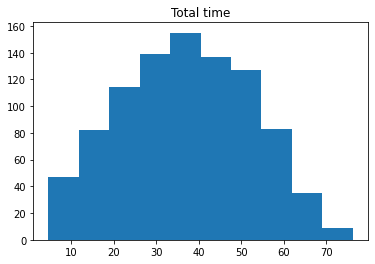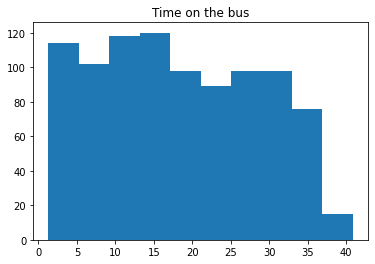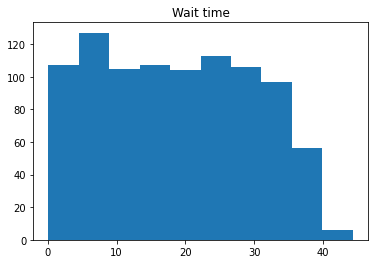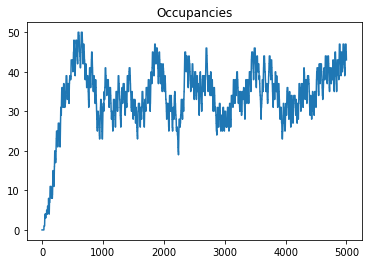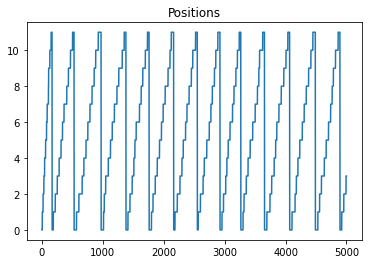

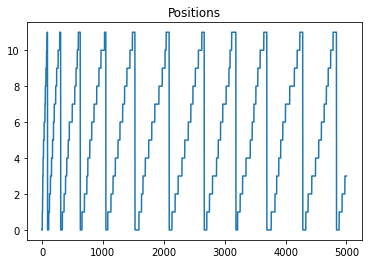

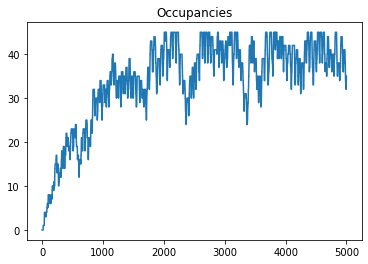

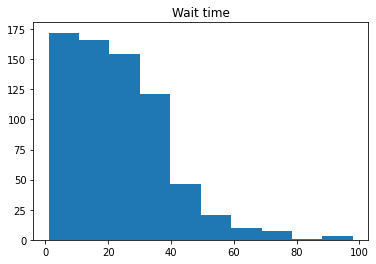

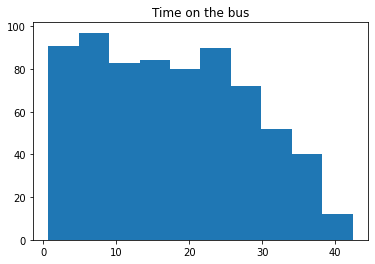

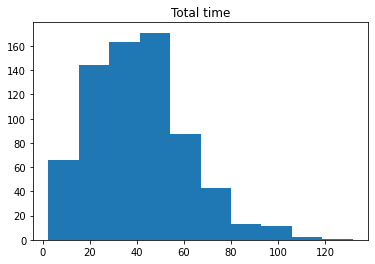

In [12]:
sim = Simulation(trace=False, person_rate=2,
                 num_stops=12,
                 bus_nextstop_time=2, bus_max_capacity=45, num_buses=1)

sim.start()

for _ in range(5000):
    sim.step()

sim.plot()


Here is some code that will help us test your implementation.

In [13]:
def check_all_stops(locations, num_stops):
    """The bus stops at all stops"""
    for i in range(len(locations) - 1):
        if locations[i] is not None:
            assert (locations[i] == locations[i + 1] or
                    (locations[i] + 1) % num_stops == locations[i + 1]), (locations[i], locations[i + 1])


In [14]:
def check_occupancies(sim):
    for bus_idx in range(sim.num_buses):
        for oc in sim.occupancies[bus_idx]:
            assert 0 <= oc <= sim.bus_max_capacity


In [15]:
def check_no_ghosts(locations):
    """The location is always defined, except possibly at the beginning."""
    for i in range(len(locations) - 1):
        if locations[i] is not None:
            assert locations[i + 1] is not None


In [16]:
def count_tours(locations):
    n = 0
    for i in range(len(locations) - 1):
        if locations[i] == 0 and locations[i + 1] == 1:
            n += 1
    return n


In [17]:
def check_simulation(sim):
    sim.start()
    for _ in range(10000):
        sim.step()
    simulation_time = sim.simulator.time
    min_tours = sim.simulator.time / (4 * sim.num_stops *
                                    (sim.bus_nextstop_time + 10 * sim.bus_geton_time))

    # Checks the bus tours.
    for bus_idx in range(sim.num_buses):
        check_all_stops(sim.positions[bus_idx], sim.num_stops)
        check_no_ghosts(sim.positions[bus_idx])
        assert count_tours(sim.positions[bus_idx]) > min_tours
    # Checks occupancies.
    check_occupancies(sim)


Let us test your implementation with this one-bus simulation.

In [18]:
### 20 points: Tests for one bus

sim = Simulation(trace=False, person_rate=2,
            num_stops=12,
            bus_nextstop_time=2, bus_max_capacity=50, num_buses=1)

check_simulation(sim)

# Let us check that the times are reasonable.
travel_times = [p.travel_time for p in sim.have_arrived]
total_times = [p.elapsed_time for p in sim.have_arrived]
wait_times = [p.wait_time for p in sim.have_arrived]
print("Travel:", np.average(travel_times), np.quantile(travel_times, 0.90))
print("Total:", np.average(total_times), np.quantile(total_times, 0.90))
print("Wait:", np.average(wait_times), np.quantile(wait_times, 0.90))
assert 15 < np.average(travel_times) < 24
assert 30 < np.quantile(travel_times, 0.9) < 40
assert 35 < np.average(total_times) < 48
assert 50 < np.quantile(total_times, 0.9) < 75
assert 18 < np.average(wait_times) < 25
assert 30 < np.quantile(wait_times, 0.9) < 48



Travel: 19.27017888122663 35.55718927377174
Total: 44.223805869891656 71.90525080887102
Wait: 24.95362698866502 44.41583711311421


### Two buses

Good.  Let us try to make life easier for our passengers, and increase the number of buses to two.  Will this cut the wait time in half? 

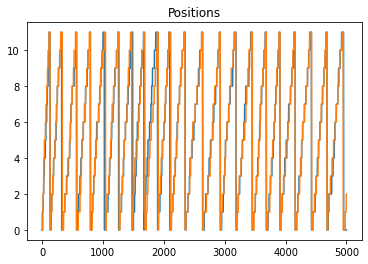

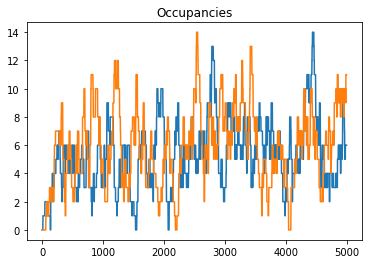

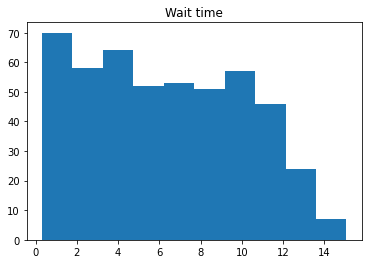

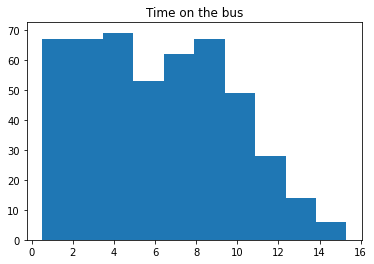

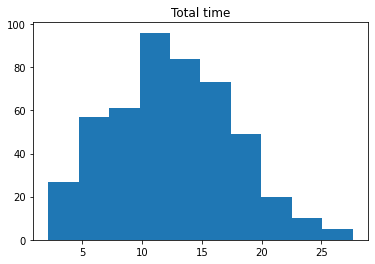

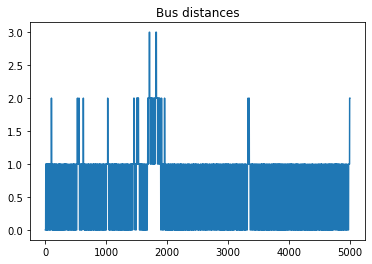

In [19]:
sim = Simulation(trace=False, person_rate=2,
                 num_stops=12,
                 bus_nextstop_time=2, bus_max_capacity=50, num_buses=2)

sim.start()

for _ in range(5000):
    sim.step()

sim.plot()


Interesting.  What happens to wait and travel times? What do the buses do?  How do you explain the result?  What insight do you derive from the simulation? 

Here are some tests. 

In [20]:
### 30 points: Tests for two buses

sim1 = Simulation(trace=False, person_rate=2,
            num_stops=12,
            bus_nextstop_time=2, bus_max_capacity=50, num_buses=1)

sim2 = Simulation(trace=False, person_rate=2,
            num_stops=12,
            bus_nextstop_time=2, bus_max_capacity=50, num_buses=2)

sim1.start()
for _ in range(10000):
    sim1.step()

check_simulation(sim2)

